In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_squared_error


# ESTUDO IMPORTANTES PARAR ESTUDAR
https://www.datacamp.com/tutorial/lstm-python-stock-market
https://www.analyticsvidhya.com/blog/2021/12/stock-price-prediction-using-lstm/

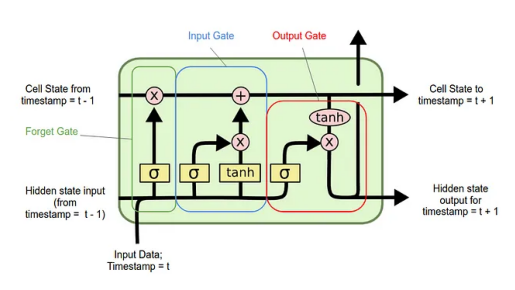

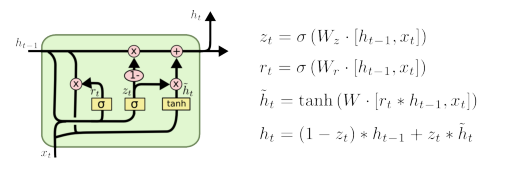

In [2]:
import matplotlib.image as img

imagem = img.imread('lstm.webp')
plt.imshow(imagem)
plt.axis('off')
plt.show()

imagem = img.imread('LSTM3-var-GRU.png')
plt.imshow(imagem)
plt.axis('off')
plt.show()

# CARREGANDO DADOS

In [3]:
dados = pd.read_csv("PETR4.SA_maior.csv")
dados.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,5.875,5.875,5.875,5.875,1.549026,3.538944e+10
1,2000-01-04,5.550,5.550,5.550,5.550,1.463335,2.886144e+10
2,2000-01-05,5.494,5.494,5.494,5.494,1.448570,4.303360e+10
3,2000-01-06,5.475,5.475,5.475,5.475,1.443560,3.405568e+10
4,2000-01-07,5.500,5.500,5.500,5.500,1.450152,2.091264e+10


# TRATAMENTO DOS DADOS NULOS

In [4]:
dados[dados.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
1261,2004-11-02,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dados = dados.dropna()
dados[dados.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


# VISUALIZANDO DADOS

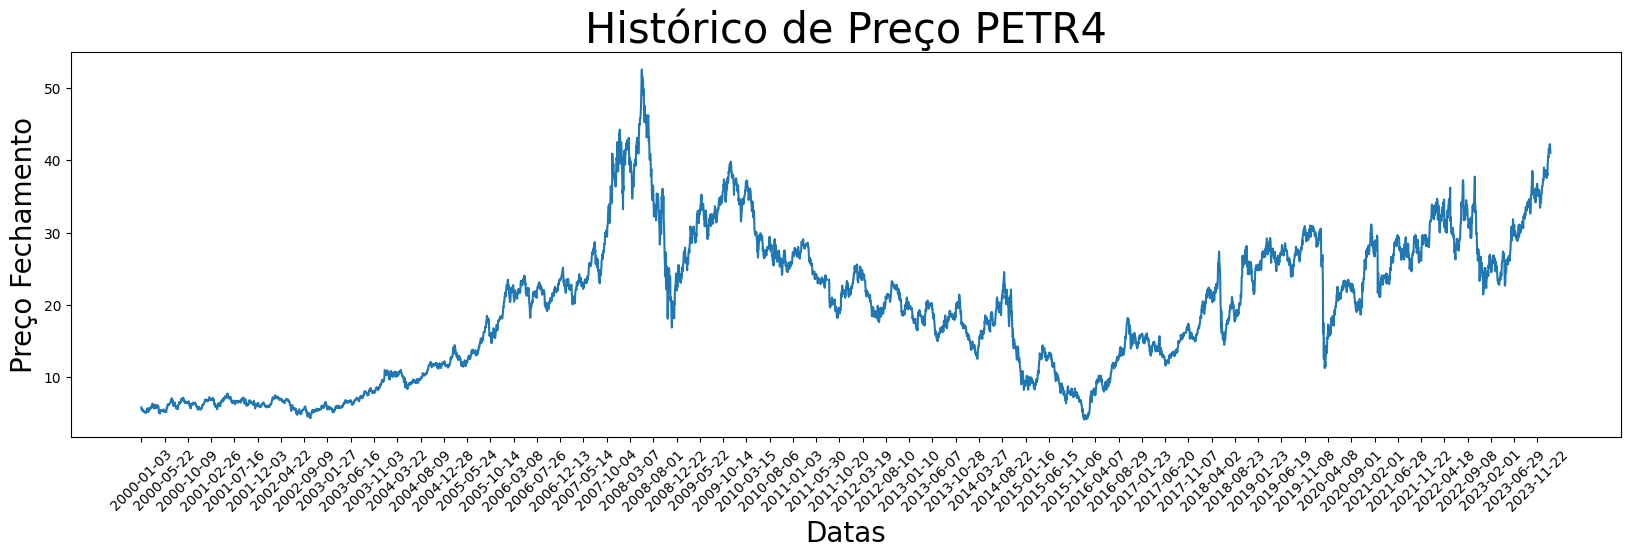

In [6]:
plt.figure(figsize = (20,5))

plt.plot(dados['Close'])
plt.xticks(range(0,dados.shape[0], 100), dados['Date'].loc[::100], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Fechamento', fontsize=20)
plt.title("Histórico de Preço PETR4", fontsize=30)

plt.show()

In [7]:
days_time_step = 15
precos = dados['Close']

# SEPARANDO TREINO E TESTE

In [8]:
size_treino = int(len(precos) * 0.90)
size_teste = len(precos) - size_treino

dados_treino, input_data = np.array(precos[0:size_treino]), np.array(precos[size_treino - days_time_step:])
dados_teste = np.array(precos[size_treino:])

print(dados_treino.shape, input_data.shape, dados_teste.shape)

(5450,) (621,) (606,)


# VISUALIZANDO INPUT DADOS

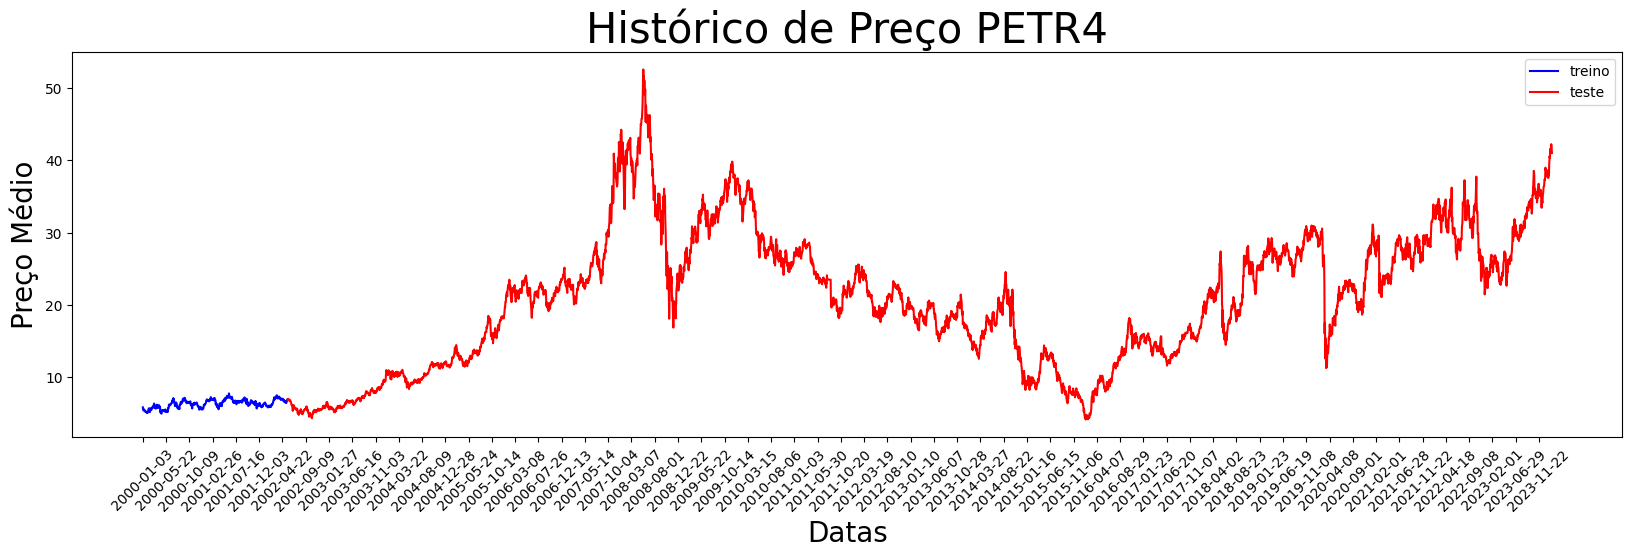

In [9]:
plt.figure(figsize = (20, 5))

plt.plot(dados['Close'].loc[0: input_data.shape[0]], color = 'blue', label = 'treino')
plt.plot(dados['Close'].loc[input_data.shape[0]: ], color = 'red', label = 'teste')
plt.xticks(range(0, dados.shape[0], 100), dados['Date'].loc[: : 100], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Médio', fontsize=20)
plt.title("Histórico de Preço PETR4", fontsize=30)

plt.legend()
plt.show()

# VISUALIZANDO DADOS TESTE

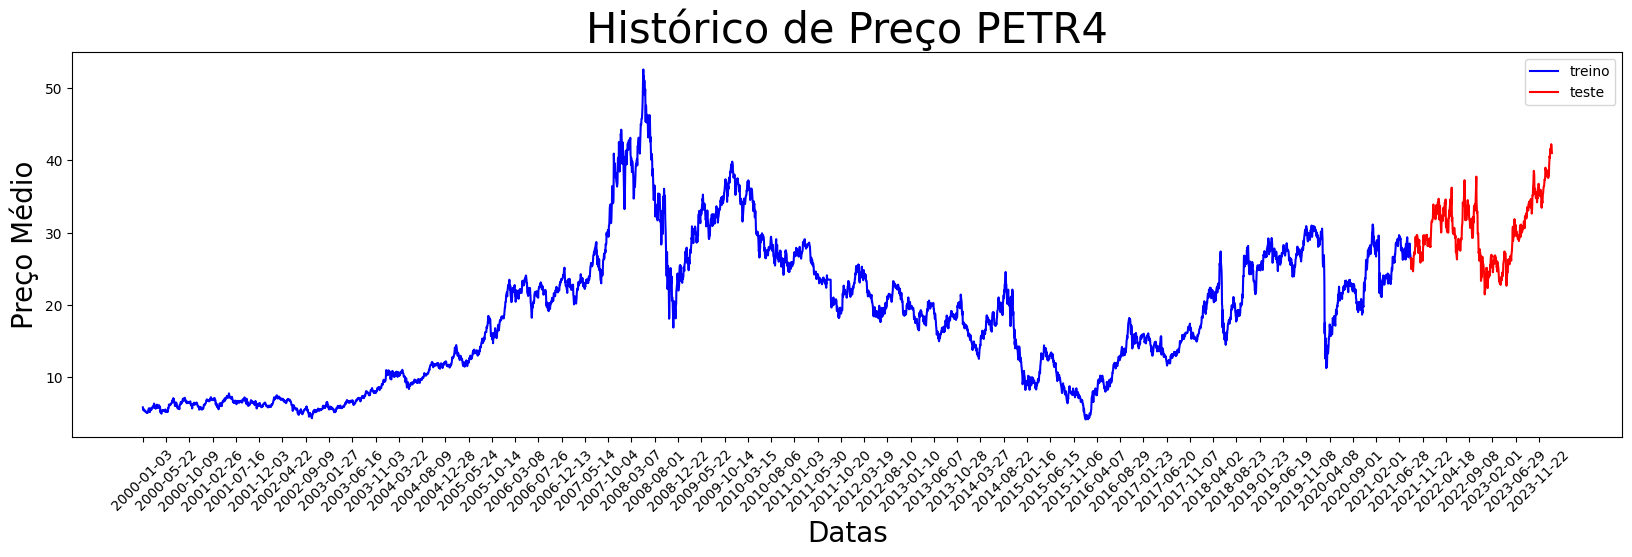

In [10]:
plt.figure(figsize = (20, 5))

plt.plot(dados['Close'].loc[0: dados_treino.shape[0]], color = 'blue', label = 'treino')
plt.plot(dados['Close'].loc[dados_treino.shape[0]: ], color = 'red', label = 'teste')
plt.xticks(range(0, dados.shape[0], 100), dados['Date'].loc[: : 100], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Médio', fontsize=20)
plt.title("Histórico de Preço PETR4", fontsize=30)

plt.legend()
plt.show()

# NORMALIZANDO DADOS

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))

dados_treino_norm = scaler.fit_transform(np.array(dados_treino).reshape(-1,1))
dados_teste_norm = scaler.transform(np.array(input_data).reshape(-1,1))
dados_validos_norm = scaler.transform(np.array(dados_teste).reshape(-1,1))

print(dados_treino_norm.shape, dados_treino_norm)

(5450, 1) [[0.03467191]
 [0.02794453]
 [0.02678535]
 ...
 [0.46367214]
 [0.45808323]
 [0.46077417]]


# GERANDO X E Y

In [12]:
X_train, y_train = [], []
for i in range(days_time_step, len(dados_treino)):
    X_train.append(dados_treino_norm[i-days_time_step:i])
    y_train.append(dados_treino_norm[i])
    
X_test = []
for i in range(days_time_step, days_time_step + len(dados_teste)):
    X_test.append(dados_teste_norm[i-days_time_step:i])
    
X_val, y_val = [], []
for i in range(days_time_step, len(dados_teste)):
    X_val.append(dados_validos_norm[i-days_time_step:i])
    y_val.append(dados_validos_norm[i])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_train.shape, X_val.shape, X_test.shape)

(5435, 15, 1) (591, 15, 1) (606, 15, 1)


# CRIANDO ARQUETETURA DA REDE NEURAL LSTM

In [13]:
modelo = Sequential()

modelo.add(LSTM(100, return_sequences=True, input_shape=(days_time_step, 1)))
#modelo.add(Dropout(0.3))
modelo.add(LSTM(100, return_sequences=False, input_shape=(days_time_step, 1)))
#modelo.add(Dropout(0.3))
modelo.add(Dense(1))

modelo.compile(loss='mse', optimizer='adam')

modelo.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# TREINANDO MODELO

In [14]:
historico = modelo.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100

170/170 [==============================] - 11s 31ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 2/100
170/170 [==============================] - 4s 22ms/step - loss: 5.3815e-04 - val_loss: 8.6005e-04
Epoch 3/100
170/170 [==============================] - 4s 22ms/step - loss: 5.2322e-04 - val_loss: 8.1792e-04
Epoch 4/100
170/170 [==============================] - 4s 24ms/step - loss: 3.7525e-04 - val_loss: 6.1497e-04
Epoch 5/100
170/170 [==============================] - 4s 22ms/step - loss: 3.4335e-04 - val_loss: 5.3475e-04
Epoch 6/100
170/170 [==============================] - 4s 21ms/step - loss: 2.9241e-04 - val_loss: 6.2939e-04
Epoch 7/100
170/170 [==============================] - 4s 21ms/step - loss: 2.7296e-04 - val_loss: 4.3145e-04
Epoch 8/100
170/170 [==============================] - 4s 23ms/step - loss: 2.3451e-04 - val_loss: 5.0085e-04
Epoch 9/100
170/170 [==============================] - 4s 24ms/step - loss: 2.2980e-04 - val_loss: 4.0605e-04
Epoch 10/100
170

# VISUALIZANDO TREINAMENTO

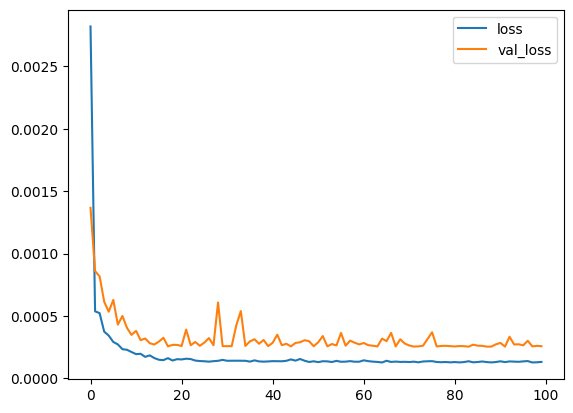

In [15]:
plt.plot(historico.history["loss"], label='loss')
plt.plot(historico.history["val_loss"], label='val_loss')
plt.legend()

# ANALISANDO RESULTADOS

In [17]:
previsao = model.predict(X_test)
previsao[:5]

19/19 [==============================] - 1s 9ms/step


array([[0.4613328 ],
       [0.42942148],
       [0.44106174],
       [0.43811992],
       [0.45637718]], dtype=float32)

In [18]:
previsao = scaler.inverse_transform(previsao)
real = dados_teste

print(previsao[:5])
print(real[:5])

[[26.486986]
 [24.94535 ]
 [25.50769 ]
 [25.365572]
 [26.247581]]
[24.969999 25.5      25.34     26.23     25.879999]


# REAL vs PREVISÃO

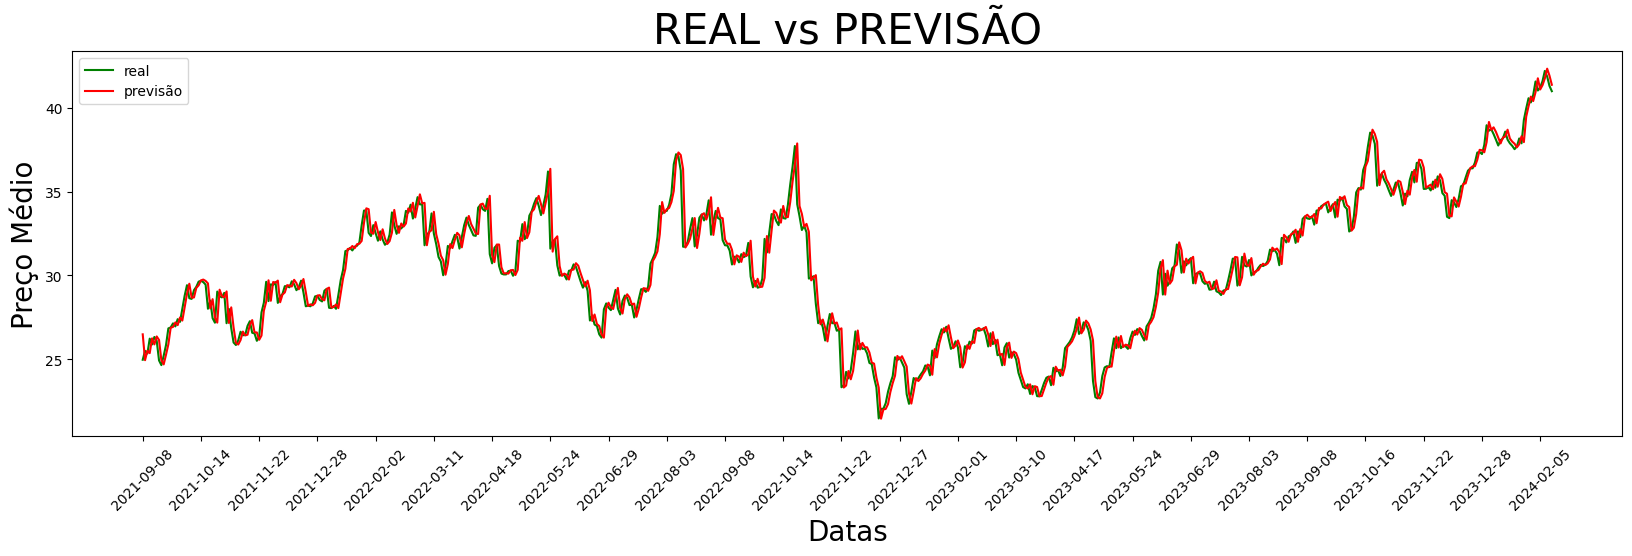

In [19]:
plt.figure(figsize = (20,5))

plt.plot(real, color = 'green', label = 'real')
plt.plot(previsao, color = 'red', label = 'previsão')

plt.xticks(range(0, len(real), 25), dados['Date'].iloc[- len(real)::25], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Médio', fontsize=20)
plt.title("REAL vs PREVISÃO", fontsize=30)

plt.legend()
plt.show()

In [25]:
mean_squared_error(real, previsao)

0.5999610254872451

# ESTIMANDO DADOS FUTUROS
sem informar o conjunto de teste todo

In [31]:
print(X_test.shape, X_test[:2, :])

(606, 15, 1) [[[0.47257301]
  [0.46760509]
  [0.4645001 ]
  [0.46367214]
  [0.47236599]
  [0.48395779]
  [0.48706274]
  [0.48209482]
  [0.50279447]
  [0.49886152]
  [0.47588495]
  [0.47278   ]
  [0.46367214]
  [0.45808323]
  [0.46077417]]

 [[0.46760509]
  [0.4645001 ]
  [0.46367214]
  [0.47236599]
  [0.48395779]
  [0.48706274]
  [0.48209482]
  [0.50279447]
  [0.49886152]
  [0.47588495]
  [0.47278   ]
  [0.46367214]
  [0.45808323]
  [0.46077417]
  [0.42993169]]]


In [30]:
previsor_x = X_test[0:1].copy() #pega o primeiro dia do conjunto de teste
projecao_futura = []

for d in range(days_time_step):
    #predição de valores pela rede
    next_t = model.predict(previsor_x)
    projecao_futura.append(next_t[0, 0])
    
    #remove primeiro preço da sequência
    temp = np.delete(previsor_x[0], 0)

    #insere último preço da sequência
    temp = np.append(temp, next_t)
    
    #recoloca no formato tensorflow
    previsor_x[0] = np.reshape(temp, (days_time_step, 1))
    
projecao_futura = scaler.inverse_transform(np.array(projecao_futura).reshape(-1, 1))

print(projecao_futura.shape, projecao_futura)

1/1 [==============================] - 0s 41ms/step
(15, 1) [[26.486986]
 [26.504248]
 [26.51684 ]
 [26.541615]
 [26.578009]
 [26.622215]
 [26.670856]
 [26.721855]
 [26.774199]
 [26.826597]
 [26.878778]
 [26.931269]
 [26.984053]
 [27.037304]
 [27.091105]]


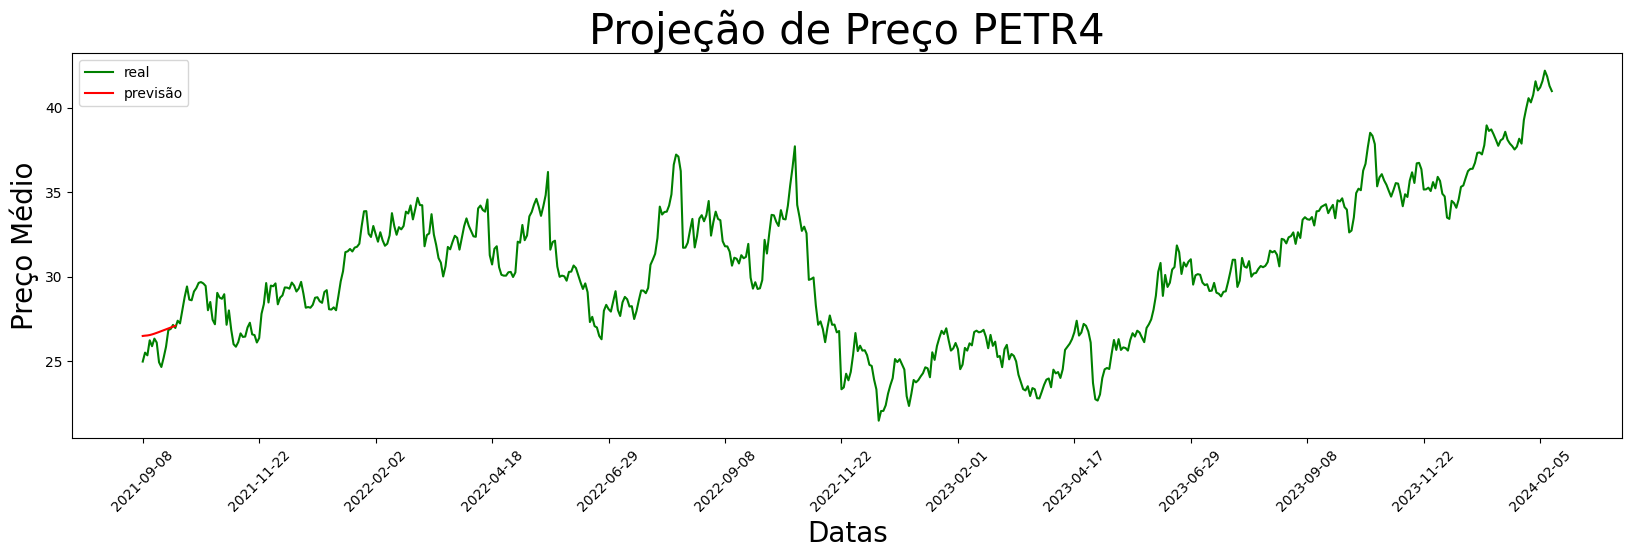

In [29]:
plt.figure(figsize = (20,5))

plt.plot(real, color = 'green', label = 'real')
plt.plot(projecao_futura, color = 'red', label = 'previsão')

plt.xticks(range(0, len(real), 50), dados['Date'].iloc[- len(real)::50], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Médio', fontsize=20)
plt.title("Projeção de Preço PETR4", fontsize=30)

plt.legend()
plt.show()

# TENTANDO ESTIMAR TODOS OS INTERVALOS DE 15 A 15 DIAS

In [ ]:
for i in range(len(X_test)):
    # Copia o intervalo de 15 dias
    print(X_test[i: i+1].copy())

In [32]:
projecao_total = []

# Iterar sobre cada intervalo de 15 dias em X_test
for i in range(len(X_test)):
    # Copia o intervalo de 15 dias
    previsor_x = X_test[i:i+1].copy()

    projecao_futura = []

    # Para cada intervalo de 15 dias, faça a projeção futura
    for d in range(days_time_step):
        # Predição de valores pela rede
        next_t = model.predict(previsor_x)
        projecao_futura.append(next_t[0, 0])

        # Remove o primeiro preço da sequência
        temp = np.delete(previsor_x[0], 0)

        # Insere o último preço da sequência
        temp = np.append(temp, next_t)

        # Recoloca no formato tensorflow
        previsor_x[0] = np.reshape(temp, (days_time_step, 1))

    # Inverte a escala para obter os valores originais
    projecao_futura = scaler.inverse_transform(np.array(projecao_futura).reshape(-1, 1))

    # Adiciona a projeção futura ao resultado total
    projecao_total.append(projecao_futura)

projecao_total = np.array(projecao_total)

print("Shape da projeção total:", projecao_total.shape)


1/1 [==============================] - 0s 51ms/step


In [ ]:
plt.figure(figsize=(20, 5))

# Plotar valores reais
plt.plot(real, color='green', label='Real')

# Iterar sobre cada projeção e plotar
for i, projecao in enumerate(projecao_total):
    # Ajustar o x para corresponder ao intervalo de 15 dias
    x_values = range(i * days_time_step, (i + 1) * days_time_step)
    
    # Plotar projeção
    plt.plot(x_values, projecao, label=f'Projeção {i+1}')

plt.xticks(range(0, len(real), 50), dados['Date'].iloc[-len(real)::50], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Médio', fontsize=20)
plt.title("Projeção de Preço PETR4", fontsize=30)

plt.legend()
plt.show()
